# Day 3 - ConvNet for car damage classification

A simple example on how ML can be used in the insurance industry

In this tutorial, our goal will be to classify different car damages. We have scraped more than 1600 images of damaged cars from google. Those were labeled according to the severity of their damage. We end up with two classes in our dataset, one for major damages (labeled as 1) and another for minor damages (labeled as 0).

To accomplish our goal to discriminate between the two, we will be using a convolutional network and we are going to implement it with PyTorch.

In [34]:
!pip3 install torch
!pip3 install torchvision
!pip3 install googledrivedownloader
!pip3 install tqdm
!pip3 install seaborn
!pip3 install Pillow==6.2.2

In [0]:
# Data downlooad
from google_drive_downloader import GoogleDriveDownloader # to get the dataset

# Deep learning and manipulation
import numpy as np
import torch.nn as nn # contains deep learning utilities
import torch # contains many useful functions for tensor operations
from torch.optim import Adam # our optimizer for back-propagation
from torch.utils.data import Dataset, DataLoader # data manipulation
from torchvision import transforms # feature transformation

#Evaluation
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, roc_auc_score, log_loss # Receiver operating characteristic curve
from sklearn.metrics import confusion_matrix

#Visualization
from tqdm import tqdm_notebook as tqdm # progress bar
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import seaborn as sns

torch.manual_seed(1111)
np.random.seed(1111)

Let's download and load our data in memory

In [0]:
CARS_ID = "1ivyijC97Zf85vZHXUhNxkvSEnmej1iBh"
GoogleDriveDownloader.download_file_from_google_drive(file_id=CARS_ID,
                                                      dest_path='./car_damages_1600',
                                                      unzip=True)

We will keep only the first 850 examples of each class to have a balanced dataset for our experiment. This will make our binary predictions easier to do (if we choose a probability threshold of 0.5).

In [0]:
N=850
major = np.load('./major_damages.npy')[:N]
minor = np.load('./minor_damages.npy')[:N]

We will create our own labels and merge the two classes.

In [62]:
images = np.vstack([major, minor])
labels = np.vstack([np.ones(N)[:, None], np.zeros(N)[:,None]])
images.shape

(1700, 256, 256, 3)

Notice the shape of our examples. We obtain 3 dimension tensors.

1. The first dimension is the number of examples or our batch size
2. The second dimension is the number of channels of our image, i.e. the red, green and blue pixel values.
3. Third and fourth dimensions are the height and width of each image.

Each value of this tensor represents a pixel red, green or blue value. It can take values between 0 and 255.

\* Note the max value of 255 as it will be used later for normalization.

In [63]:
images.max(), images.min()

(255, 0)

The following function can help us visualize our images. The images were previously resized to 256x256 pixels. It is easier to train a convnet when the images have a square size because we can specify only one kernel dimension.

In [0]:
def plot_4_random(images, title=''):
        
    idx = np.random.randint(len(images),size=(2,2))
    
    fig, axes = plt.subplots(2,2)

    for i in range(2):
        for j in range(2):
            axes[i][j].imshow(images[idx[i,j]],)
            axes[i][j].get_xaxis().set_visible(False)
            axes[i][j].get_yaxis().set_visible(False)
            axes[i][j].set_frame_on(False)
    
    fig.set_size_inches((14,14))
    fig.suptitle(title, y=0.95)
    
    return idx

Let's check what our data looks like. You may find two images that look very similar or one that seems to belong to the wrong class. It is a dataset obtained by a google search and then manually filtered, it could happen that some images appear in the wrong class.

array([[412, 311],
       [741, 337]])

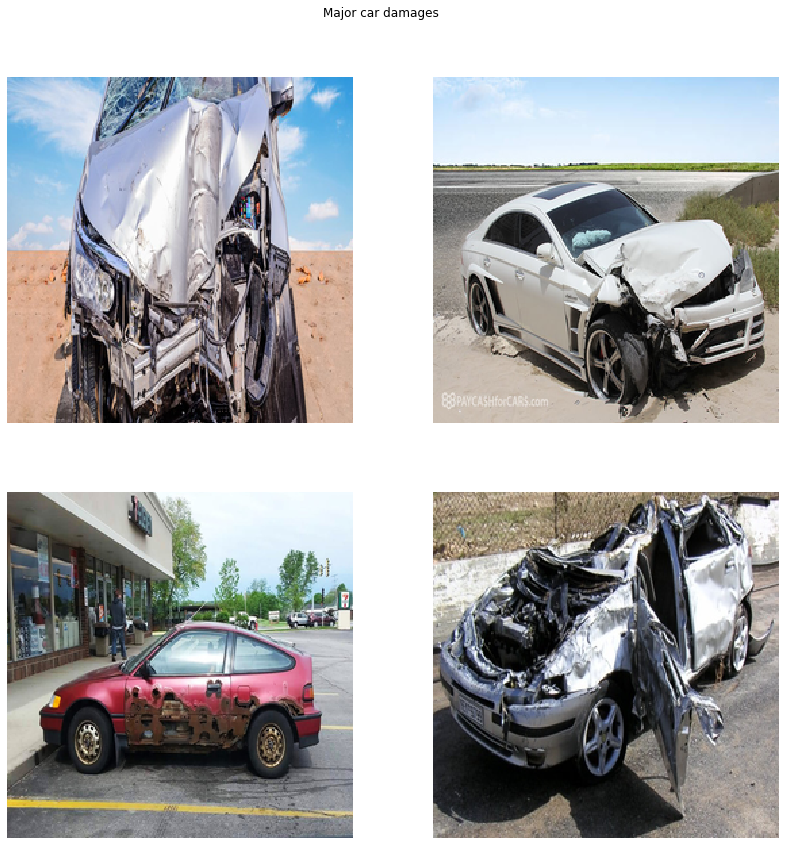

In [65]:
plot_4_random(images[labels.flatten()==1], title='Major car damages')

array([[396, 674],
       [692, 152]])

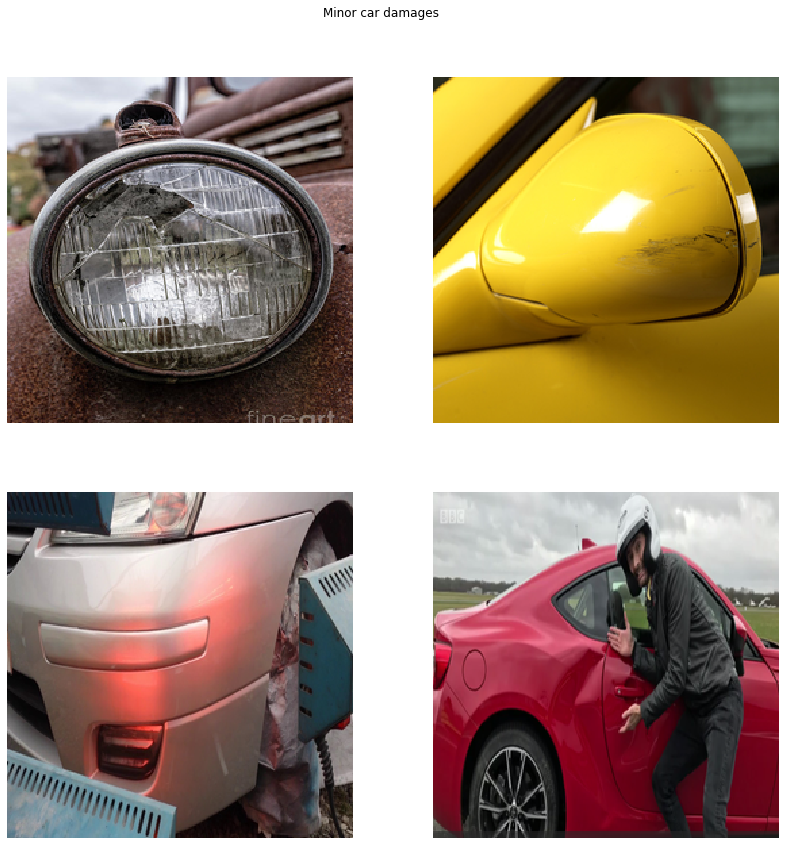

In [66]:
plot_4_random(images[labels.flatten()==0], title='Minor car damages')

Note again that this dataset is far from perfect. Since some pictures contain text, it is possible that the algorithm will recognize each image based on this text instead of the damages they contain.

# Torch's Dataset class

Provides an API for torch's DataLoader to access specific examples of our dataset. In practice one could train models without this class or the DataLoader. However, for large datasets that do not fit in memory, the DataLoader can help us load examples as we need them without overloading memory. The DataLoader can do it parallely to save time and we can specify a num_workers argument.

In [0]:
class CarDataset(Dataset):

    def __init__(self, images, labels, transform=None):

        # In torch, the 2nd dimension should be the RGB values of an image
        # if you use Keras or TF instead, the RGB values will be on the last dimension
        self.images = torch.tensor(np.moveaxis(images,[3],[1])).float()
        self.labels = torch.tensor(labels).long()
        
        
        # We will apply a random rotation to our images.
        # Features of CNN are not scale or rotation invariant, although they are translation invariant.
        # This way, we will help the CNN learn features from different perspectives.
        
        self.transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.RandomRotation(20),
                                             transforms.ToTensor()])
        
        # The last transformation, ToTensor, scales each pixel value to a value between 0 and 1
        # by dividing each pixel by 255.

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        X = self.transform(self.images[idx])
        y = self.labels[idx]
        sample = {'images': X, 'labels': y}

        return sample

Let's split our data set in train, validation and test sets. We will keep 60% for training, 20% for validation and 20% for testing.

In [68]:
car_dataset = CarDataset(images, labels)

train_size = int(len(car_dataset)*0.6)
valid_size = test_size = int(len(car_dataset)*0.2)

splits = torch.utils.data.random_split(car_dataset, [train_size, valid_size, test_size])

train_set, valid_set, test_set = splits

len(train_set) + len(valid_set) + len(test_set)

1700

# The CNN architecture

Every time we define a convolution layer with Torch, we need to input three arguments:

1. in_channels is the third dimension of each image, i.e. the red, green and blue values.
2. out_channels represents the number of different patterns that we are looking for, it will be the second dimension of the output tensor of this layer.
3. kernel_size is the width and height of the convolution window that we are going to "slide" on our image.

There are other optional arguments that we can consider, like the the stride, the padding and the dilation. However, we will not tweak those in this tutorial. We will use torch's default values.

The output size of a convolutional layer is:

$$ O = \frac{W - K + 2P}{S} + 1$$

- W is the input width and height (square input)
- K is the filter size
- P is the padding
- S is the stride

By default, the stride and the padding are 1 and 0 respectively in torch for Conv2D layers*. 
For MaxPool2d layers, the stride takes the value of the kernel window size by default. 

*If the resulting output width is not an integer, torch will omit the last columns of the input to make it an integer.


In [69]:
def get_output_size(w, list_of_ks, list_of_ps):
    
    """
    w: the input's height and width
    list_of_ks: list of kernel size
    list_of_ps: list of max pooling size
    
    """
    
    if len(list_of_ks) != len(list_of_ps):
        raise Exception('Kernel size and pooling size list lengths must be equal.')
    
    # We use torch's default padding of zero and stride 1 for simplicity
    p=0
    s=1

    # for convolution
    # Notice the floor function, we use it because torch will omit columns to make the ouput size an integer
    w = np.floor((w - list_of_ks[0] + 2*p) / s + 1)
    
    
    # for pooling, by default the stride equals the kernel size in torch but can be changed
    w = np.floor((w - list_of_ps[0] + 2*p) / list_of_ps[0]  + 1)
    
    if len(list_of_ks)>1:
        return get_output_size(w, list_of_ks[1:], list_of_ps[1:])
    else:
        return int(w)
    
get_output_size(256, [3,3,3,3], [3,3,3,3])

2

In [0]:
class CNN(nn.Module):
  
    def __init__(self, hidden_units, input_width):
        
        super(CNN, self).__init__()
        
        # 1st layer
        # In-channels, out-channels, kernel_size
        # In practice, small kernel sizes like 3 with with more layers work best
        self.conv1 = nn.Conv2d(3,8,3)
        # the activation fonction used is max(0, x) applied element-wise
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(3) 
        
        # 2nd layer
        self.conv2 = nn.Conv2d(8,8,3) # By default, torch's uses Xavier uniform initialization (see slides)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(3)
        
        # 3rd layer
        self.conv3 = nn.Conv2d(8,16,3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(3)
        
        # 4th layer
        self.conv4 = nn.Conv2d(16,32,3)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(3)
        
        # ... we could use more or less layers, but 4 layers work well for this problem.
        
        # The output of last layer is 32 x 2 x 2, we can flatten this tensor and use
        # a fully connected layer, like a final output MLP, for the prediction
        
        final_width = get_output_size(input_width, [3,3,3,3], [3,3,3,3])
        
        self.fc1 = nn.Linear(32*final_width**2, hidden_units)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        
        # We have to reshape (flatten) the output of the convolutional+pooling layers
        # before feeding it into the dense layers.
        x = self.fc1(x.view(-1,32*2*2))
        x = self.relu5(x)
        x = self.fc2(x)
        
        return torch.sigmoid(x)

In [70]:
CNN(64, 256).forward(torch.ones((1,3,256,256))).size() == (1,1) # check if our output size is correct

True

Here we define our hyperparameters, feel free to tweak them and experiment with different combinations. Also, because of the high computational cost of our task, we will be using a GPU. To let PyTorch know that we use a GPU instead of a CPU, we will need to specify our device and mount all torch tensors on it.


In [0]:
DEVICE = 'cuda:0' if torch.cuda.device_count()>0 else 'cpu:0'

In [0]:
HIDDEN_UNITS = 32
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.001

In [0]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [74]:

# Instantiate our CNN with a choice of hidden units
net = CNN(HIDDEN_UNITS, 256).to(DEVICE)

# We need an optimizer for our network params, Adam is a popular and good choice.
optimizer = Adam(net.parameters(), lr=LEARNING_RATE)

# And a loss function, BCE (for binary crossentropy) is used for binary classification, 
# where we have a sigmoid function at the end of our network's output.
criterion = nn.BCELoss().to(DEVICE)
        
# Two dicts of lists to keep track of loss and auroc during training
historical_loss = {'train':[], 'valid':[]} 


for epoch in range(EPOCHS):
    
    
    epoch_train_loss = []
    epoch_valid_loss = []
    
    for batch in tqdm(train_loader):
        

        inputs, targets = batch['images'].to(DEVICE), batch['labels'].to(DEVICE)

        predictions = net(inputs)
        loss = criterion(predictions, targets.float())
        epoch_train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        
        for batch in valid_loader:
        
            inputs, targets = batch['images'].to(DEVICE), batch['labels'].to(DEVICE)

            predictions = net(inputs)
            loss = criterion(predictions, targets.float())
            epoch_valid_loss.append(loss.item())
            
    epoch_train_loss = np.mean(epoch_train_loss)
    epoch_valid_loss = np.mean(epoch_valid_loss)
    
    historical_loss['train'].append(epoch_train_loss)
    historical_loss['valid'].append(epoch_valid_loss)
            
    print(f'Epoch {epoch} --- Train loss: {epoch_train_loss:.5f} --- Valid loss: {epoch_valid_loss:.5f}')


Epoch 0 --- Train loss: 0.69289 --- Valid loss: 0.69302



Epoch 1 --- Train loss: 0.69075 --- Valid loss: 0.69149



Epoch 2 --- Train loss: 0.68687 --- Valid loss: 0.68667



Epoch 3 --- Train loss: 0.67796 --- Valid loss: 0.67676



Epoch 4 --- Train loss: 0.65646 --- Valid loss: 0.65326



Epoch 5 --- Train loss: 0.62156 --- Valid loss: 0.62625



Epoch 6 --- Train loss: 0.57776 --- Valid loss: 0.57611



Epoch 7 --- Train loss: 0.53456 --- Valid loss: 0.55595



Epoch 8 --- Train loss: 0.49926 --- Valid loss: 0.51471



Epoch 9 --- Train loss: 0.48127 --- Valid loss: 0.51597



Epoch 10 --- Train loss: 0.46470 --- Valid loss: 0.50758



Epoch 11 --- Train loss: 0.45758 --- Valid loss: 0.49401



Epoch 12 --- Train loss: 0.44191 --- Valid loss: 0.48801



Epoch 13 --- Train loss: 0.45154 --- Valid loss: 0.52526



Epoch 14 --- Train loss: 0.47294 --- Valid loss: 0.47809



Epoch 15 --- Train loss: 0.44551 --- Valid loss: 0.46701



Epoch 16 --- Train loss: 0.44080 --- Valid loss: 0.47424



Epoch 17 --- Train loss: 0.44554 --- Valid loss: 0.46729



Epoch 18 --- Train loss: 0.43383 --- Valid loss: 0.48650



Epoch 19 --- Train loss: 0.42743 --- Valid loss: 0.50858


Let's visualize how the training went.

Text(0, 0.5, 'Log-loss')

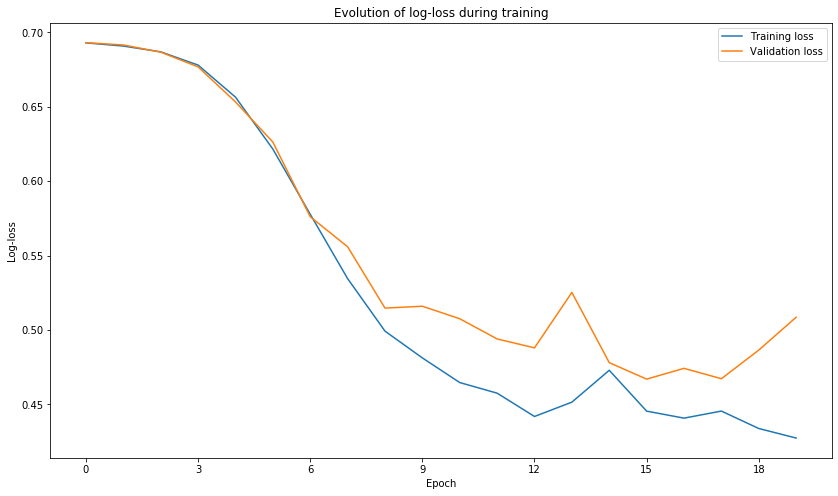

In [75]:
ax = plt.figure(figsize=(14,8))

plt.plot(historical_loss['train'], label='Training loss')
plt.plot(historical_loss['valid'], label='Validation loss')

ax.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Evolution of log-loss during training')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Log-loss')


We can now evaluate our classifier's performance on the reserved test set.

In [76]:
with torch.no_grad():

    test_preds = []
    test_labels = []
    
    for batch in tqdm(test_loader):
        
        inputs = batch['images'].to(DEVICE)
        targets = batch['labels']
        
        test_preds.append(net(inputs).cpu().detach().numpy())
        test_labels.append(targets.numpy())
    
    test_preds, test_labels = np.vstack(test_preds), np.vstack(test_labels)

Using a confusion matrix, we can visualize how good our classifier is at identyfing each class.

Text(87.0, 0.5, 'Predicted value')

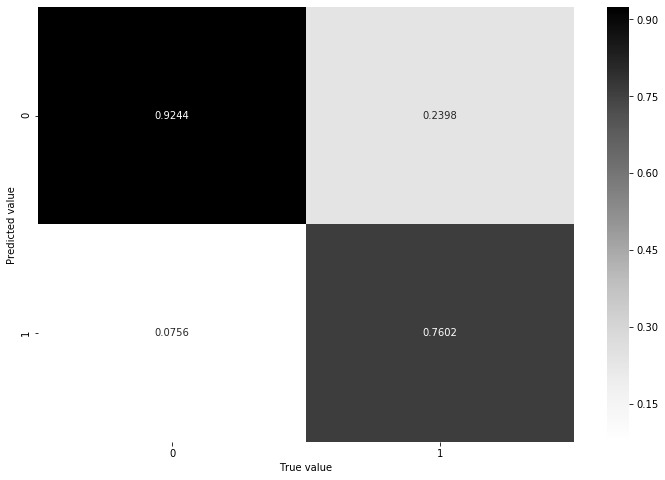

In [77]:

decision_threshold = 0.5

test_acc = (test_labels==(test_preds>decision_threshold)).mean()
test_loss = log_loss(test_labels, test_preds)

plt.figure(figsize=(12,8))

conf_mat = confusion_matrix(test_labels, test_preds>decision_threshold)
conf_mat = conf_mat/conf_mat.sum(axis=0)

sns.heatmap(conf_mat, annot=True, cmap='Greys', fmt='.4f')

plt.xlabel('True value')
plt.ylabel('Predicted value')

Another great way to evaluate a binary classifier without explicitely choosing a threshold is to visualize the ROC curve. It is equivalent to evaluating the classifier at every possible threshold between 0-1.

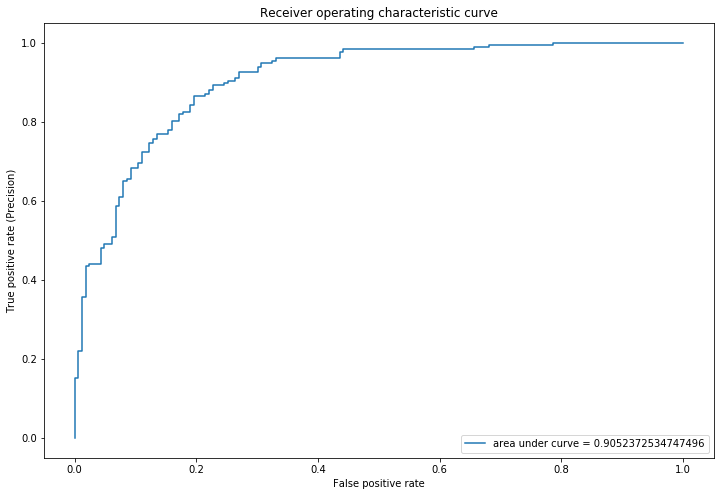

In [78]:

fpr, tpr, _ = roc_curve(test_labels,  test_preds)
auc = roc_auc_score(test_labels,  test_preds)

plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label="area under curve = "+str(auc))
plt.title('Receiver operating characteristic curve')
plt.legend(loc=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate (Precision)')
plt.show()

Is our area under curve indicating that we have a good classifier?